## Nearest neighbor searches on geodataframes with cKDTree and RTree

When searching for nearest neighbors one can achieve tremendous speedups with a method that works on a spatial index.  Geopandas makes it easy to create a spatial index using RTree but there is in fact a faster method available using Scipy's cKDTree which can be vectorized.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import random

## cKDTree

In the practical application described later we load two geodataframes. One labeled the `schools` gdf contains locations and column data on all 1822 schools in NYC and the another gdf `lpis` holds locations and data on 3019 street intersections with Leading Pedestrian Interval Signals (lpis).  We want to find the nearest school to each of the 3019 lpis intersections.

### Demo with simulated data

First a small simulated example with N=50 to illustrate and visualize what's going on.  The `cKDTree` method reads locations as numpy arrays. We'll use `nschools` and `nlpis` names to play along with the example. 

Rather than longitude and latitude we just use cartesian coordinates in (0,2000)X(0,2000) space. We'll create two arrays with 50 locations each.

In [2]:
N = 50
nschools = np.random.uniform(0., 2000., (N, 2))  

Suppose that we want to find the K nearest neighbors to a specific LPIS intersection (we illustrate by choosing one more or less in middle of the 'map')

In [3]:
lpispoint = np.array([1000,1000])

**Build the cKDTree spatial index**

In [4]:
tree = cKDTree(nschools)

A query to the tree returns the k nearest neighbors to lpispoint.  The query returns two arrays, the first with distances and the second with index positions. 

In [5]:
K = 4
dist, idx = tree.query(lpispoint, k=K)
dist, idx

(array([113.16525307, 132.24189913, 185.59781908, 241.4231384 ]),
 array([18, 28,  7, 38]))

This returns the distance to the nearest neighbor as well as the index position in the tree/array. We can then retrieve the nearest school location to lpispoint using the returned index positions.

In [6]:
nschools[idx]

array([[1071.09630633, 1088.0436808 ],
       [1043.96759786,  875.28123548],
       [ 947.42976124, 1177.99696751],
       [ 796.62027177,  869.91611206]])

Here is a visualization of what's going on. Our lpispoint is the green square and the K nearest neighbors are stars.

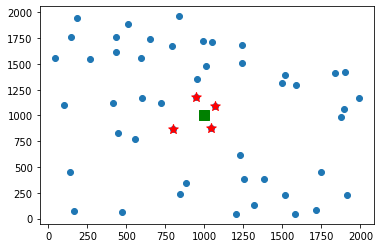

In [7]:
plt.scatter(nschools[:,0],nschools[:,1])
plt.scatter(lpispoint[0],  lpispoint[1] ,s=100,c='g', marker="s")
plt.scatter([nschools[i][0] for i in idx], [nschools[i][1] for i in idx], c='r', marker="*",s=100);

The great thing about cKDTree queries is that they can be vectorized. 

Let's now raise the challenge and search for nearest neighbors to 10000 locations for which we have 10000 possible neighbors. If we were doing this by brute force we'd have to do 100 million distance calculations which would be very costly.  The spatial index greatly reduces this.

In [8]:
N = 10000
nschools = np.random.uniform(0., 5000., (N, 2))  
nlpis = np.random.uniform(0., 5000., (N, 2))  

In [9]:
tree = cKDTree(nschools)

In [10]:
%%timeit
dist, idx = tree.query(nlpis,k=1)

9.19 ms ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### cKDTree using geodataframes

Usually we'd have geospatial data stored in geopandas dataframes, so let's write a wrapper function to work with some real world data.

In [11]:
schools = gpd.read_file('schools.shp')
schools.tail(2)

,school_nam,ft_lon,ft_lat,ID,geometry
1820,Bronx Charter School for Better Learning,1028689.0,261519.0,1821,POINT (1028689 261519)
1821,Bronx Charter School for the Arts,1015670.0,238707.0,1822,POINT (1015670 238707)


In [12]:
lpis = gpd.read_file('lpis.shp')
lpis.tail(2)

,LPID,main_stree,cross_stre,geometry
3017,3017,Fillmore Avenue,Stuart Street,POINT (1000985.999980557 160476.999962011)
3018,3018,116 Avenue,207 Street,POINT (1054721.00012189 193597.9999928418)


## A `ckdnearest` function

The following is a wrapper function to make nearest neighbor queries easy using geodaframes.  The function extracts the location data as numpy arrays from the respective geometries.

In [13]:
def ckdnearest(gdA, gdB, bcol):
    """
    This function takes geodataframes: `gdA` and `gdB` and 
    a column name `bcol` from the latter. Both dataframes are assumed to 
    have a `geometry` column. It finds the nearest neighbor 
    from each location in `gdA` to its nearest neighbor in `gdB`.  

    It returns a two-column pandas dataframe with a `distance`
    (here rounded to nearest foot)  and the value of 
    the `bcol` value from `gdB`  (e.g. 'school_name')
    """
    
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist,
                             'bcol' : gdB.loc[idx, bcol].values })
    return df

The function returns a dataframe whose tail looks like this:

In [14]:
ckdnearest(lpis, schools,'school_nam').head(3)

,distance,bcol
0,1699.617953,Cornerstone Academy for Social Action
1,479.718598,Success Academy Charter School - Harlem 1
2,558.127103,P.S. 242 - The Young Diplomats Magnet Academy


Since the returned dataframe is on the same index as the `gdA` we can simply add the returned dataframe as new columns to the original dataframe. Like this:

In [15]:
lpis[['distance_to_school','nearest_school']] = ckdnearest(lpis, schools,'school_nam')
lpis.head(2)

,LPID,main_stree,cross_stre,geometry,distance_to_school,nearest_school
0,0,Co-op City Blvd,Dreiser loop East,POINT (1031739.000154228 259373.000004255),1699.617953,Cornerstone Academy for Social Action
1,1,Lenox Avenue,West 119 St,POINT (998570.9998893011 232184.9999184268),479.718598,Success Academy Charter School - Harlem 1


In [16]:
%%timeit
ckdnearest(lpis, schools,'school_nam')

81.3 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Additional notes

What follows are a few unfinished notes on alternative methods.

## RTree nearest method

Geopandas has built in the use of [Rtree](http://toblerity.org/rtree/) to build a spatial index and this then offers a `nearest` method, which can be used as illustrated below.  

There are two reasons why this method is going to be slower:

1. we seemingly cannot vectorize the operation as we did above, so we'll have to loop over all the points that we want to find nearest neighbors for. This will be slow.
2. the Rtree nearest method returns the index of the nearest neighbor(s) but not the distance, so we are going to have to calculate that separately.

It's interesting to understand how an RTree spatial index works:

>"An R-tree represents individual objects and their bounding boxes (the “R” is for “Rectangle”) as the lowest level of the spatial index. It then aggregates nearby objects and represents them with their aggregate bounding box in the next higher level of the index. At yet higher levels, the R-tree aggregates bounding boxes and represents them by their bounding box, iteratively, until everything is nested into one top-level bounding box.

>To search, the R-tree takes a query box and, starting at the top level, sees which (if any) bounding boxes intersect it. It then expands each intersecting bounding box and sees which of the child bounding boxes inside it intersect the query box. This proceeds recursively until all intersecting boxes are searched down to the lowest level, and returns the matching objects from the lowest level.([source](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/))" 

The 'points' that we search from will also be indicated by their bounding boxes.

In [17]:
srtindex = schools.sindex

Here is an example point (note how points are indicated by their 'bounding box'):

In [18]:
lp_point = lpis.loc[1428,'geometry'].bounds
lp_point

(1016305.3948666304,
 212446.98788534413,
 1016305.3948666304,
 212446.98788534413)

The nearest neighbor is returned as an index position in the schools dataframe.

In [19]:
list(srtindex.nearest(lp_point))

[1751]

One issue is that the method often returns 2 or more indices when they are (approximately) equidistant. In the code below we 

We can then use that index to pull out that dataframe row:

In [20]:
schools.iloc[list(srtindex.nearest(lp_point))]

,school_nam,ft_lon,ft_lat,ID,geometry
1751,Renaissance Charter School,1016164.0,212519.0,1752,POINT (1016164 212519)


In [21]:
gdA = schools    
gdA.head(2)

,school_nam,ft_lon,ft_lat,ID,geometry
0,P.S. 015 Roberto Clemente,990141.0,202349.0,0,POINT (990141 202349)
1,P.S. 019 Asher Levy,988547.0,205239.0,1,POINT (988547 205239)


Let's try to build a helper function to find the nearest neighbors.  One issue is that the RTree nearest method often returns two or more indices when they are (approximately) equidistant, so we'll always choose only the first.

In [22]:
nA = gdA.geometry.bounds.to_numpy()
len(nA)

1822

In [23]:
def rtnearest(gdA, gdB, bcol):

    Brtree = gdB.sindex
    
    nA = gdA.geometry.bounds.to_numpy()
    idx = np.zeros(len(nA))
    
    for pos, pt in enumerate(nA):
        idx[pos] = list(Brtree.nearest(pt))[0]
    df = pd.DataFrame.from_dict({'bcol' : gdB.loc[idx, bcol].values })
    return df

In [24]:
rtnearest(lpis, schools,'school_nam').head(2)

,bcol
0,Cornerstone Academy for Social Action
1,Success Academy Charter School - Harlem 1


In [25]:
lpis[['nearest_school']] = rtnearest(lpis, schools,'school_nam')
lpis.head(2)

,LPID,main_stree,cross_stre,geometry,distance_to_school,nearest_school
0,0,Co-op City Blvd,Dreiser loop East,POINT (1031739.000154228 259373.000004255),1699.617953,Cornerstone Academy for Social Action
1,1,Lenox Avenue,West 119 St,POINT (998570.9998893011 232184.9999184268),479.718598,Success Academy Charter School - Harlem 1


This method is somewhat slower, even without also finding the distances.

In [26]:
%%timeit
rtnearest(lpis, schools,'school_nam')

216 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
